In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger
from rl.processors import WhiteningNormalizerProcessor

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
from data import EURUSD_HOUR
from custom_env import ExternalDataFullFeature

Using TensorFlow backend.
/Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

### Using Forex-v0 with all features available and diffs

In [2]:
from custom_env import ForexV0FullFeature
def env_creator():
    return ExternalDataFullFeature(df=EURUSD_HOUR, frame_bound=(50, 80000), window_size=24)

env = env_creator()
print(env.df)
obs = env.reset()
obs_shape = obs.shape
nb_actions = env.action_space.n

def buildModel():
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + obs_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nb_actions, activation='linear'))
    return model
buildModel().summary()

def agent_creator():
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=256, window_length=1)
    policy = BoltzmannQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, gamma=0.5, enable_double_dqn=False)
    agent.compile(Adam(lr=0.001), metrics=['mae'])
    return agent

       BidOpen  BidHigh   BidLow  BidClose  BidChange  AskOpen  AskHigh  \
0      0.91680  0.91680  0.91680   0.91680    0.00000  0.91780  0.91780   
1      0.91810  0.91810  0.91810   0.91810    0.00000  0.91840  0.91840   
2      0.91520  0.91520  0.91520   0.91520    0.00000  0.91550  0.91550   
3      0.90420  0.90420  0.90420   0.90420    0.00000  0.90450  0.90450   
4      0.90920  0.90920  0.90920   0.90920    0.00000  0.90950  0.90950   
...        ...      ...      ...       ...        ...      ...      ...   
90227  1.13651  1.13714  1.13627   1.13696   -0.00045  1.13663  1.13727   
90228  1.13695  1.13695  1.13615   1.13647    0.00048  1.13709  1.13709   
90229  1.13646  1.13654  1.13573   1.13589    0.00057  1.13660  1.13698   
90230  1.13565  1.13667  1.13565   1.13652   -0.00087  1.13665  1.13716   
90231  1.13652  1.13677  1.13635   1.13648    0.00004  1.13676  1.13694   

        AskLow  AskClose  AskChange         date_time  
0      0.91780   0.91780    0.00000  2002-0

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
  131/15989 [..............................] - ETA: 27s - reward: -2.5802 - cumulative_reward: -100.0458  WARNING:tensorflow:From /Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
15989/15989 [==============================] - 178s 11ms/step - reward: -0.1244 - cumulative_reward: -874.4412
train 1 completed. took 180.495 seconds, total_reward: -1989.3999999999583 total_profit: 0.9112531210273879
min reward: -1434.8000000000004, max reward: 217.0000000000005, mean_reward: -0.02488336314400378


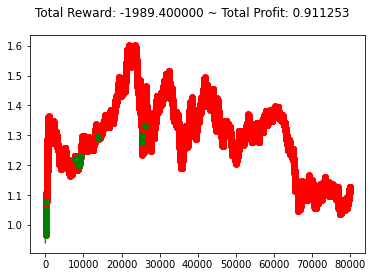

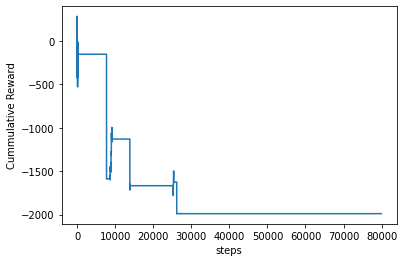

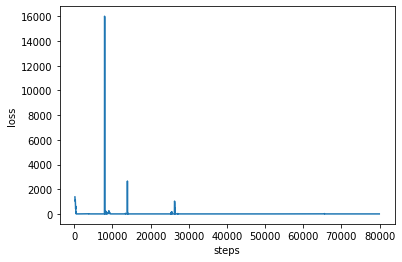

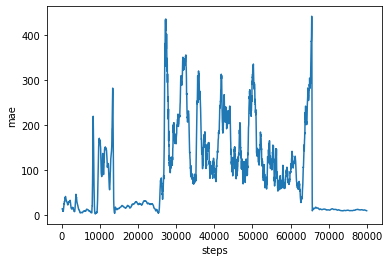

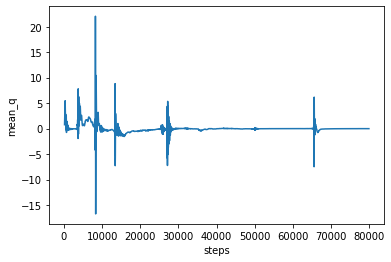

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 211s 13ms/step - reward: -0.1002 - cumulative_reward: -1992.3930
train 2 completed. took 396.537 seconds, total_reward: -1602.4999999999632 total_profit: 0.6617777706293418
min reward: -2568.799999999998, max reward: 917.2000000000003, mean_reward: -0.020044028067892822


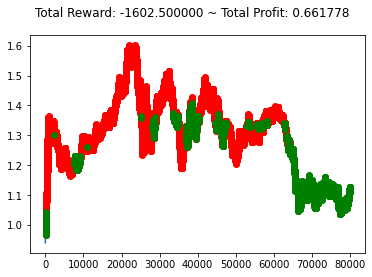

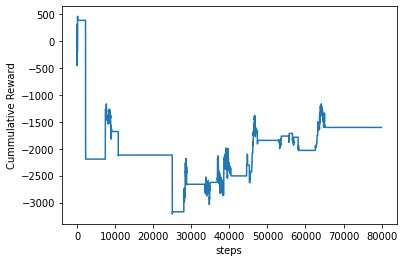

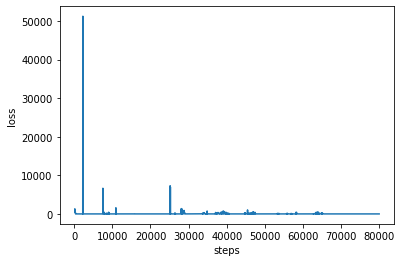

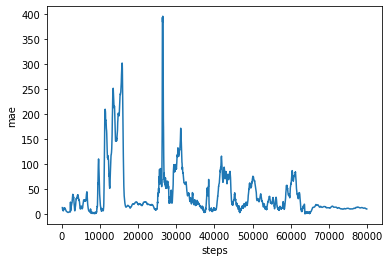

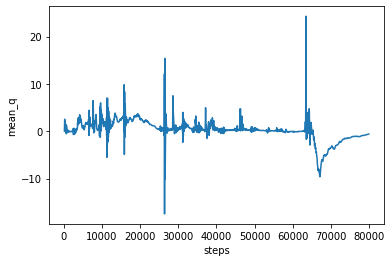

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 218s 14ms/step - reward: -0.2094 - cumulative_reward: -1186.3379
train 3 completed. took 619.825 seconds, total_reward: -3348.2999999999342 total_profit: 0.39982107345768014
min reward: -2411.1000000000017, max reward: 493.10000000000184, mean_reward: -0.04188044878610032


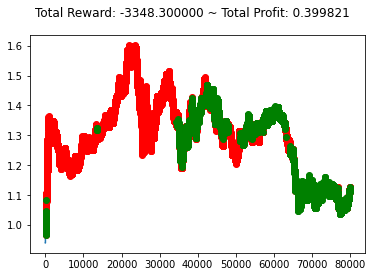

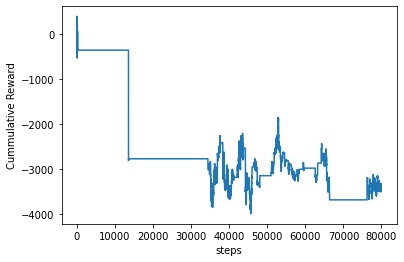

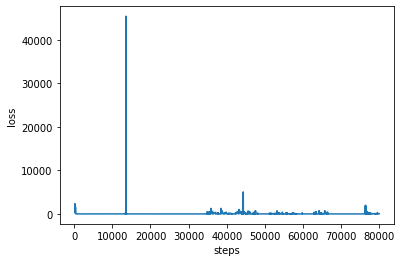

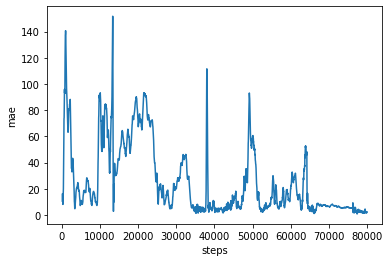

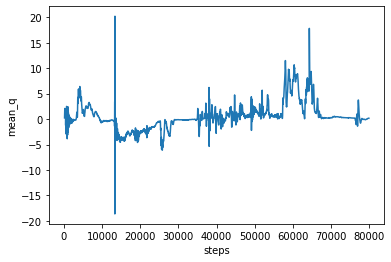

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 224s 14ms/step - reward: -0.2185 - cumulative_reward: -3456.2202
train 4 completed. took 849.128 seconds, total_reward: -3493.0999999999985 total_profit: 0.8794902938348761
min reward: -1753.7999999999986, max reward: 242.9999999999999, mean_reward: -0.04369160339716568


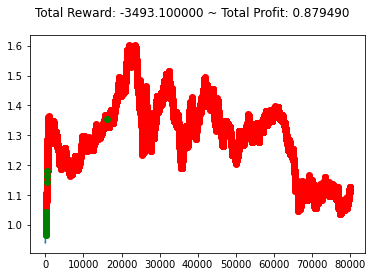

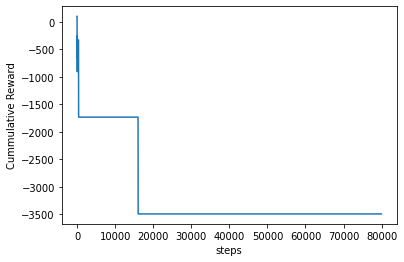

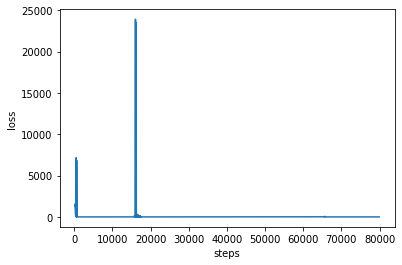

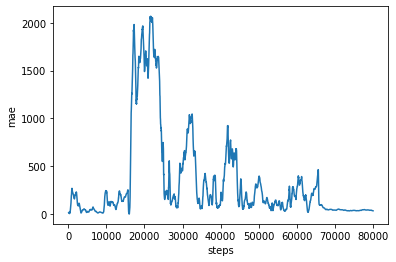

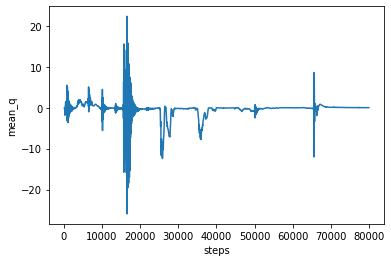

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 228s 14ms/step - reward: -5.4523 - cumulative_reward: -1524.5798
train 5 completed. took 1082.589 seconds, total_reward: 762.8999999999252 total_profit: 0.3163319750132712
min reward: -2677.0000000000005, max reward: 1082.0000000000007, mean_reward: 0.00954233323743793


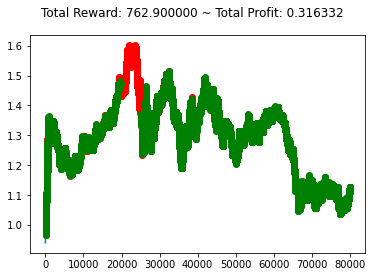

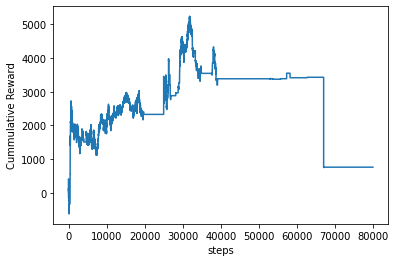

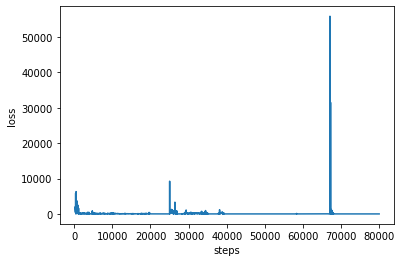

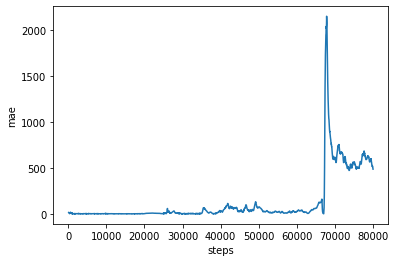

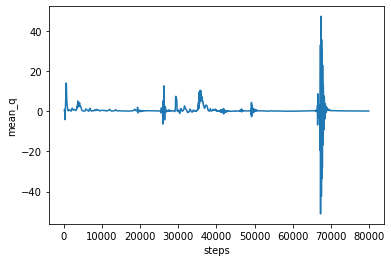

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 230s 14ms/step - reward: -0.2495 - cumulative_reward: -2731.9168
train 6 completed. took 1317.923 seconds, total_reward: -3988.7999999999834 total_profit: 0.7759725967296957
min reward: -2209.200000000002, max reward: 841.0000000000007, mean_reward: -0.049891806026341586


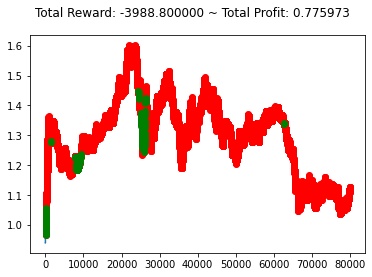

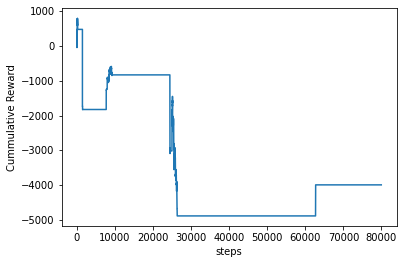

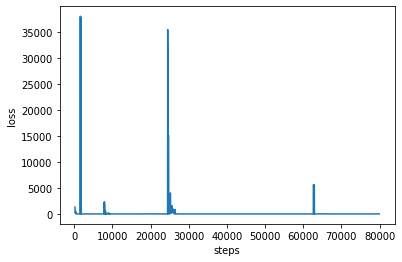

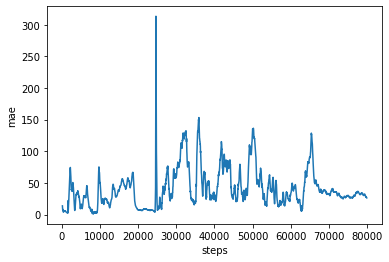

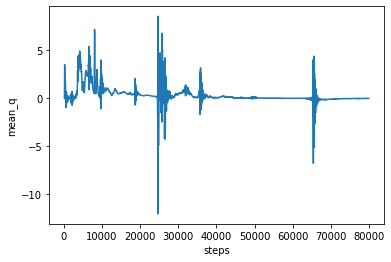

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 234s 15ms/step - reward: -6.1608 - cumulative_reward: -567.9843
train 7 completed. took 1557.631 seconds, total_reward: -2571.7 total_profit: 0.39134926601242015
min reward: -628.2999999999994, max reward: 1102.4999999999995, mean_reward: -0.032166756307145807


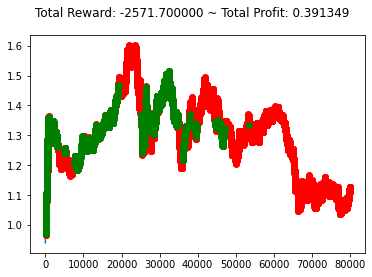

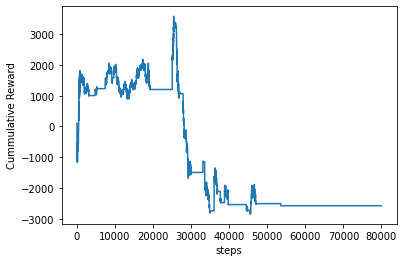

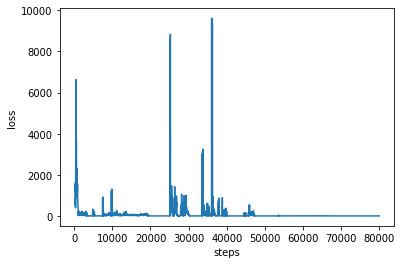

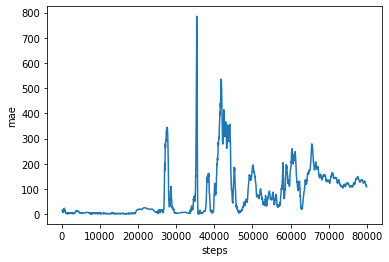

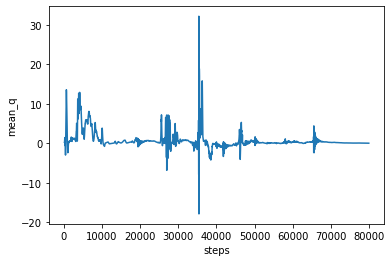

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 240s 15ms/step - reward: -0.4469 - cumulative_reward: -4725.2583
train 8 completed. took 1803.393 seconds, total_reward: -7145.899999999989 total_profit: 0.6684106503395946
min reward: -2216.799999999999, max reward: 259.20000000000164, mean_reward: -0.08938073021551225


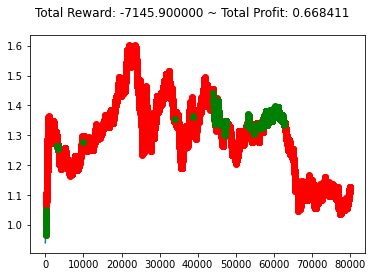

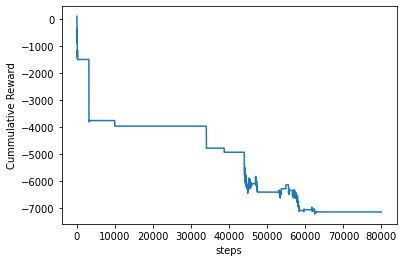

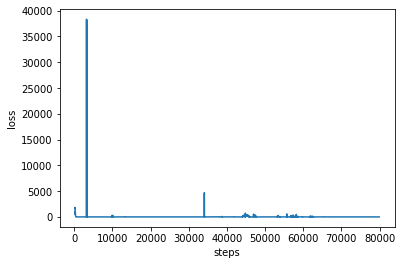

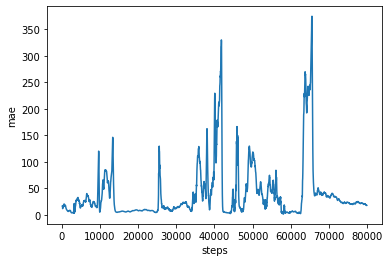

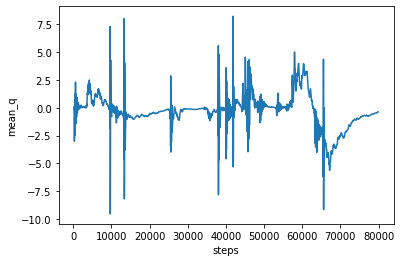

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 242s 15ms/step - reward: -0.3113 - cumulative_reward: -3155.3854
train 9 completed. took 2050.691 seconds, total_reward: -4977.600000000129 total_profit: 0.5097880571086025
min reward: -2313.2999999999984, max reward: 395.7999999999995, mean_reward: -0.06225969055272897


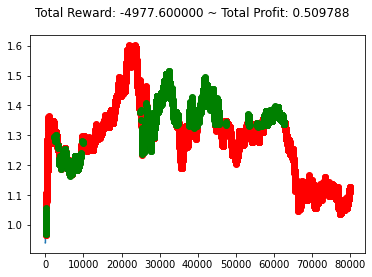

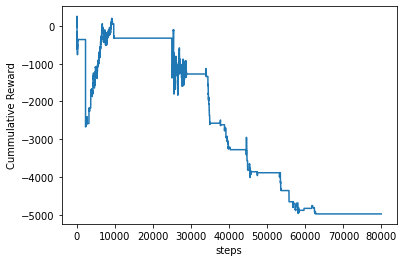

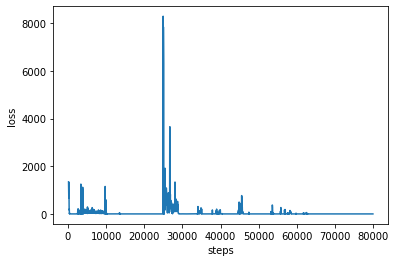

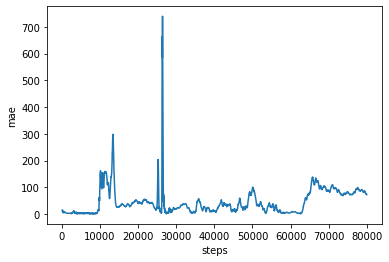

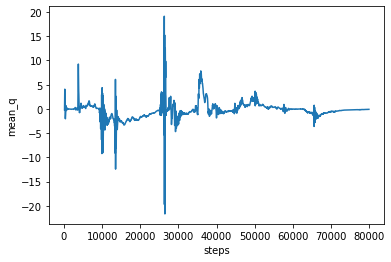

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 220s 14ms/step - reward: -0.1541 - cumulative_reward: -1017.7137
train 10 completed. took 2276.368 seconds, total_reward: -2463.9999999999636 total_profit: 0.6577891301724056
min reward: -2310.200000000002, max reward: 391.9000000000006, mean_reward: -0.030819647525296923


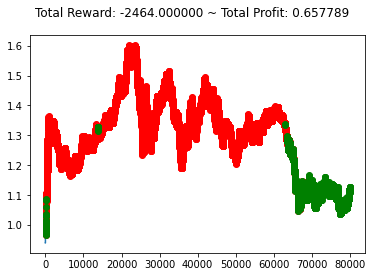

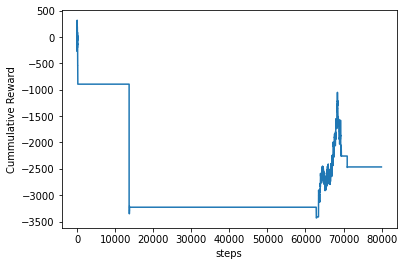

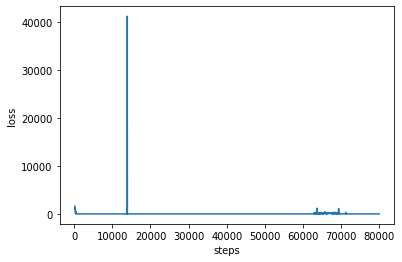

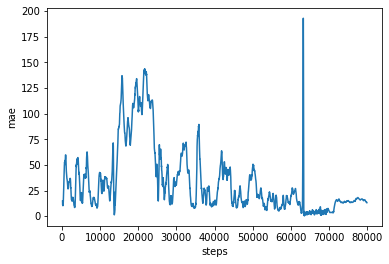

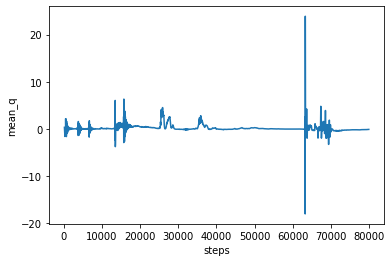

In [3]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="dqn90k")
e.train(repeat=10)


average of total_reward across trainings: [-3081.84]


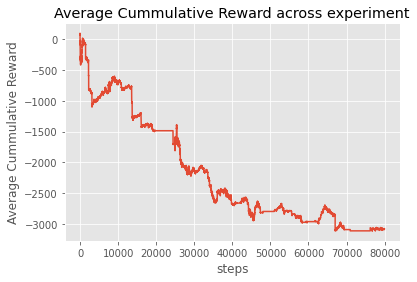

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
1999/1999 [==============================] - 15s 7ms/step - reward: -0.0046 - cumulative_reward: 58.3888
Episode 1: reward: -9.100, steps: 9999
test completed. total_reward: -9.100000000017435 total_profit: 0.9582319892359923
min reward: -287.39999999999986, max reward: 160.49999999999898, mean_reward: -0.0009100910091026538


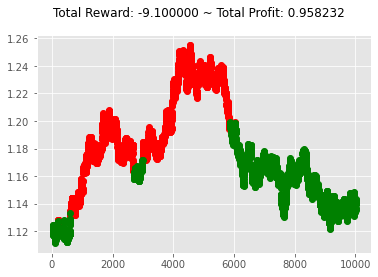

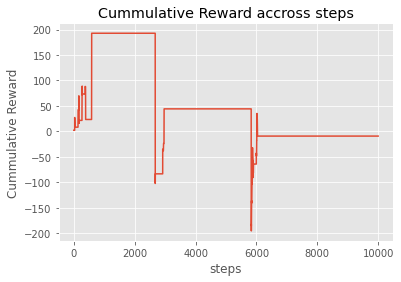

In [5]:
e.process_train_result()
e.test(ExternalDataFullFeature(df=EURUSD_HOUR, frame_bound=(80000, 90000), window_size=24))

### Double DQN

In [6]:

def agent_creator():
    #processor = EnvProcessor()
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=256, window_length=1)
    #policy = EpsGreedyQPolicy()
    policy = BoltzmannQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, gamma=0.5, enable_double_dqn=True)
    agent.compile(Adam(lr=0.001), metrics=['mae'])
    return agent

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 227s 14ms/step - reward: 0.3683 - cumulative_reward: 4129.3374
train 1 completed. took 229.909 seconds, total_reward: 5888.599999999828 total_profit: 0.5522724365869844
min reward: -517.3000000000005, max reward: 2037.4000000000003, mean_reward: 0.07365445471487858


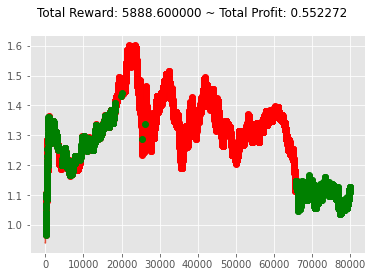

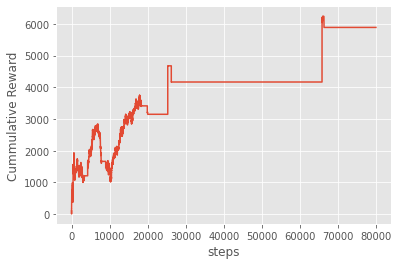

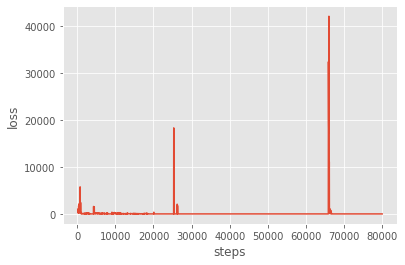

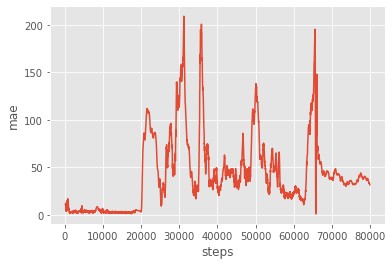

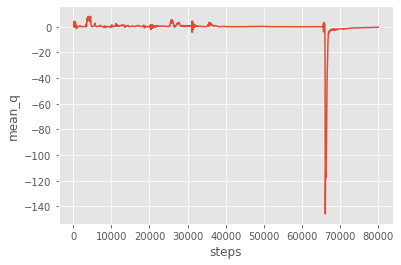

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 246s 15ms/step - reward: 0.1843 - cumulative_reward: 3754.7248
train 2 completed. took 481.793 seconds, total_reward: 2947.0999999999567 total_profit: 0.5332883027635652
min reward: -478.7000000000008, max reward: 985.9000000000018, mean_reward: 0.03686224968417312


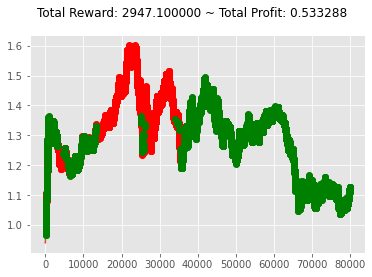

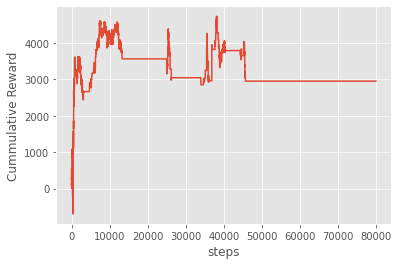

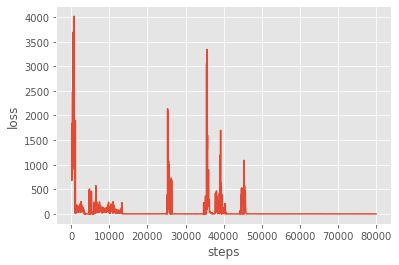

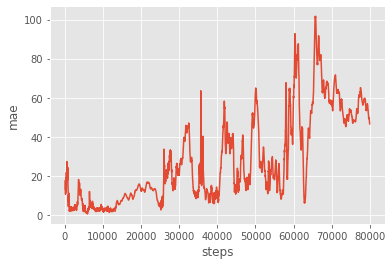

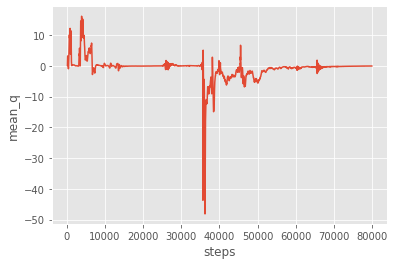

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 264s 16ms/step - reward: -0.1618 - cumulative_reward: -2759.9059
train 3 completed. took 752.002 seconds, total_reward: -2587.5999999998435 total_profit: 0.5224400754144103
min reward: -2414.2, max reward: 380.29999999999785, mean_reward: -0.03236563309109362


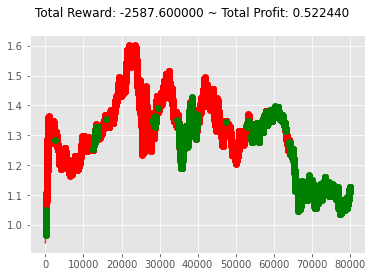

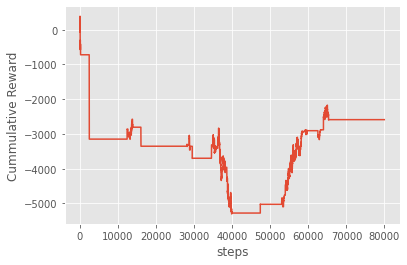

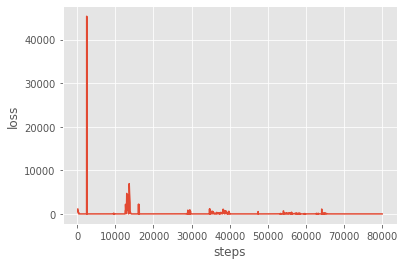

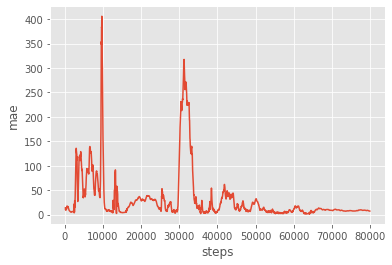

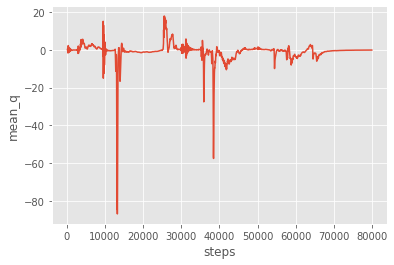

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 272s 17ms/step - reward: -0.2423 - cumulative_reward: -1694.8983
train 4 completed. took 1029.983 seconds, total_reward: -3874.800000000005 total_profit: 0.8558642443431335
min reward: -2949.2999999999993, max reward: 807.8999999999992, mean_reward: -0.04846589700934352


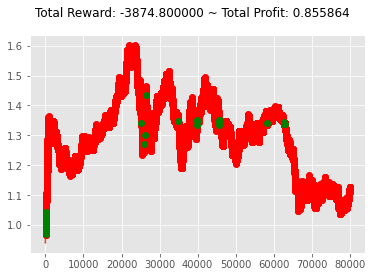

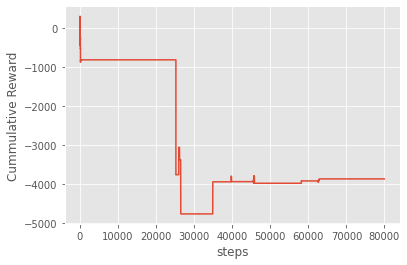

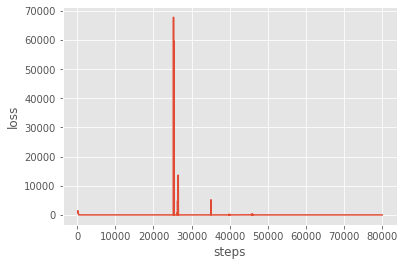

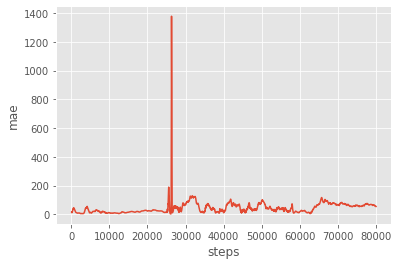

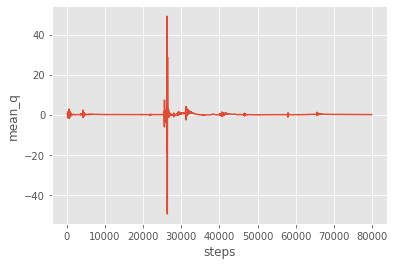

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 273s 17ms/step - reward: -0.0844 - cumulative_reward: -404.6522
train 5 completed. took 1309.849 seconds, total_reward: -1350.1999999998993 total_profit: 0.4105336730913603
min reward: -1732.5000000000014, max reward: 2112.1000000000013, mean_reward: -0.016888266269745704


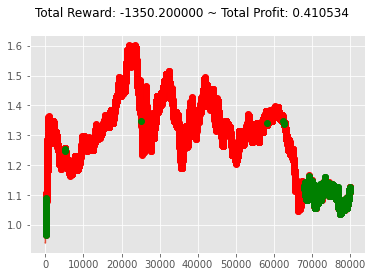

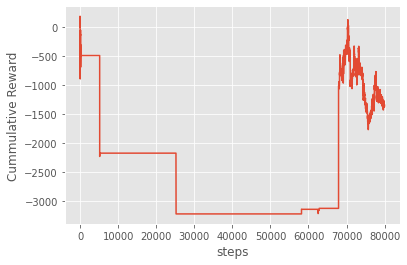

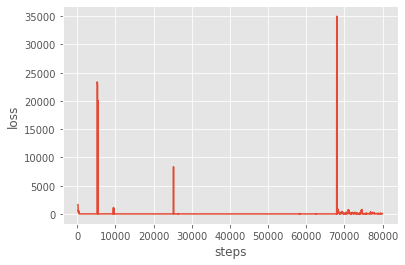

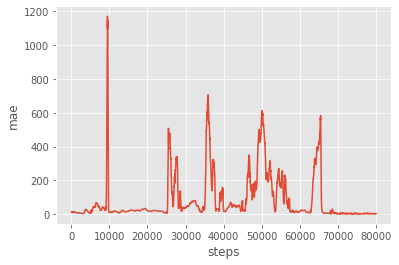

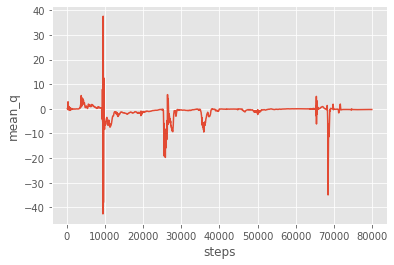

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 280s 18ms/step - reward: -0.2486 - cumulative_reward: -3952.0802
train 6 completed. took 1596.851 seconds, total_reward: -3975.800000000006 total_profit: 0.8562666251029653
min reward: -2878.6, max reward: 103.99999999999964, mean_reward: -0.049729202366508726


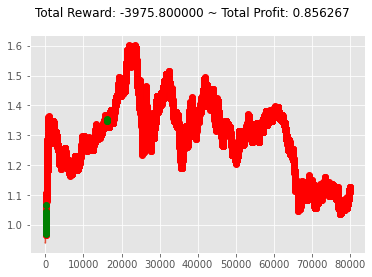

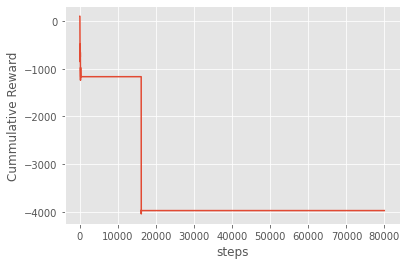

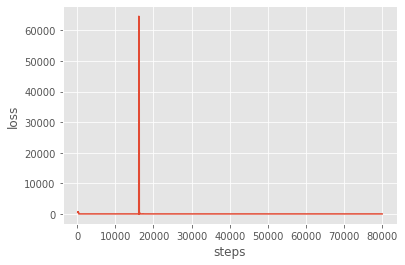

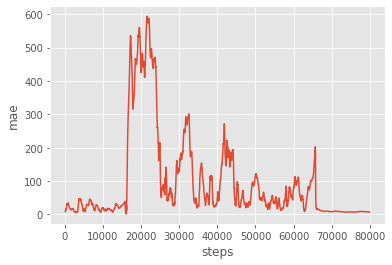

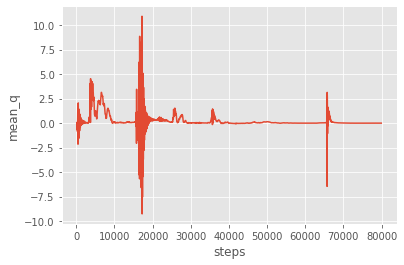

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 287s 18ms/step - reward: -1.4824 - cumulative_reward: -470.9140
train 7 completed. took 1891.308 seconds, total_reward: 281.70000000026425 total_profit: 0.2178958889970912
min reward: -847.9999999999999, max reward: 584.0000000000001, mean_reward: 0.0035234962288491945


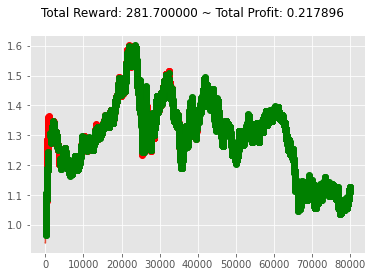

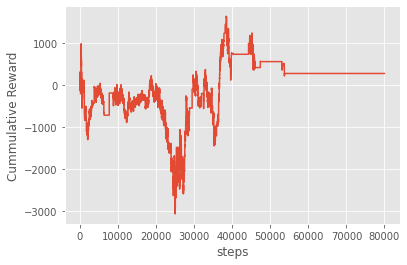

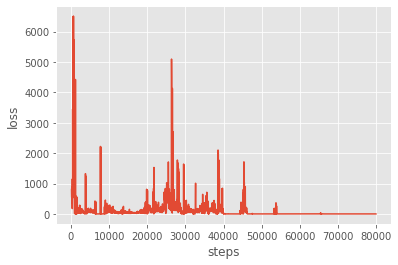

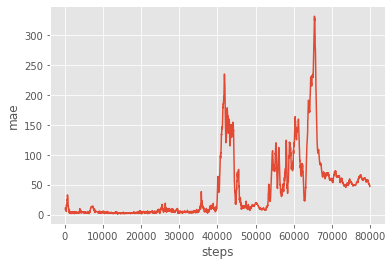

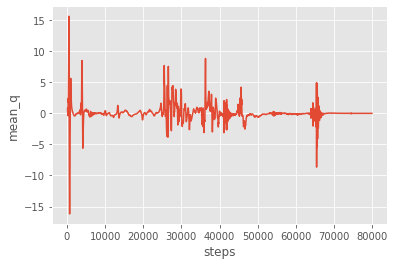

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 293s 18ms/step - reward: 47.2122 - cumulative_reward: -1278.4259
train 8 completed. took 2191.647 seconds, total_reward: -1403.3999999999685 total_profit: 0.7829679085563863
min reward: -1703.7000000000014, max reward: 809.1999999999988, mean_reward: -0.017553690477679126


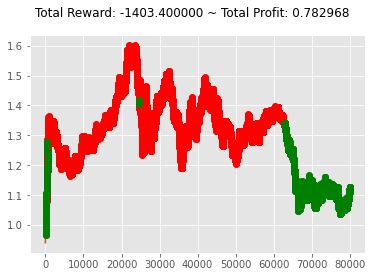

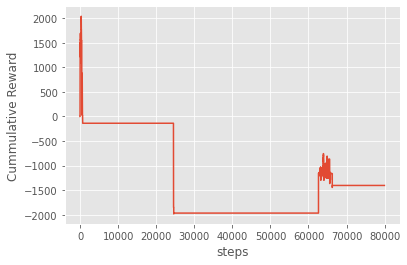

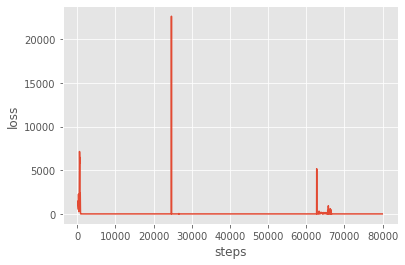

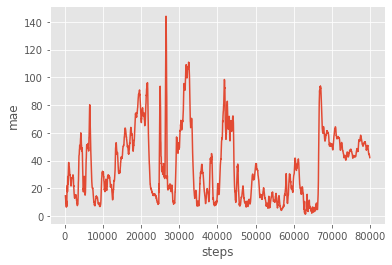

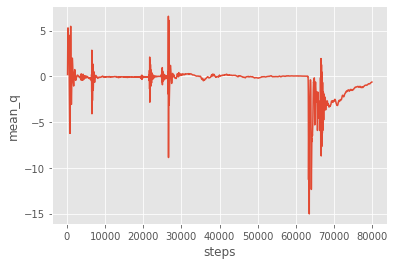

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 292s 18ms/step - reward: 0.0676 - cumulative_reward: -576.4763
train 9 completed. took 2491.563 seconds, total_reward: 1081.200000000069 total_profit: 0.6062130335471522
min reward: -3061.3, max reward: 1025.4000000000008, mean_reward: 0.013523621308585084


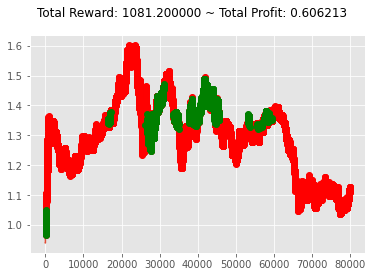

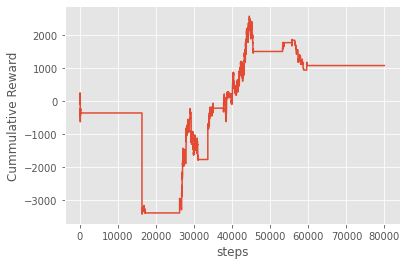

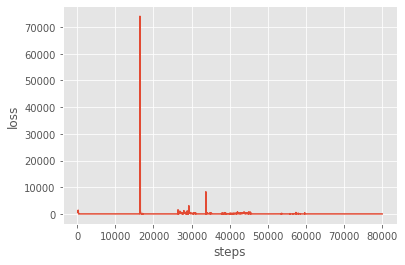

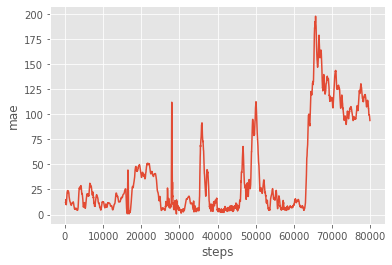

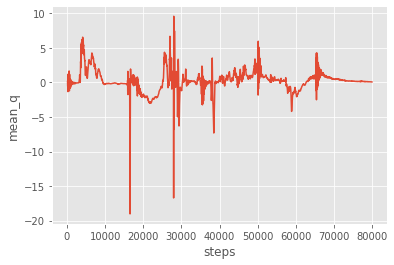

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 289s 18ms/step - reward: -0.1149 - cumulative_reward: -1391.7589
train 10 completed. took 2788.233 seconds, total_reward: -1837.299999999919 total_profit: 0.31094322577230404
min reward: -1473.9999999999998, max reward: 591.1999999999983, mean_reward: -0.02298090032395551


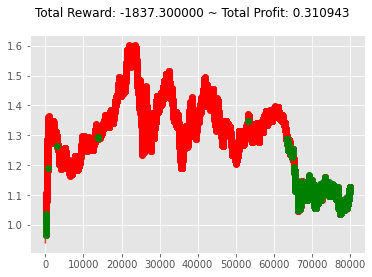

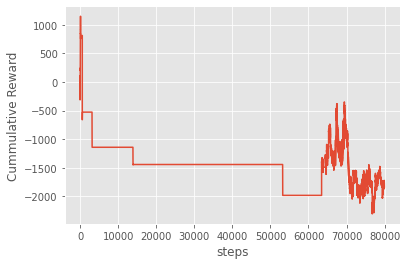

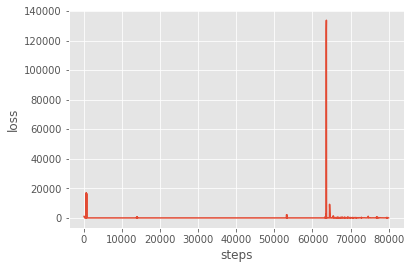

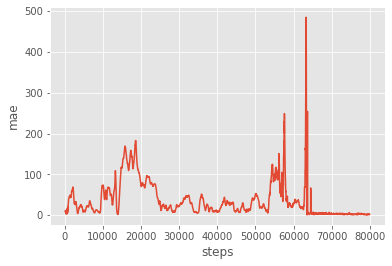

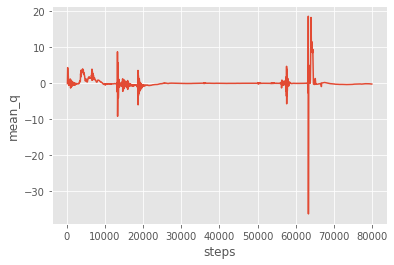

In [7]:
e = Evaluator(agent_creator, env_creator, name="doubledqn-90k")
e.train(repeat=10)

average of total_reward across trainings: [-483.05]


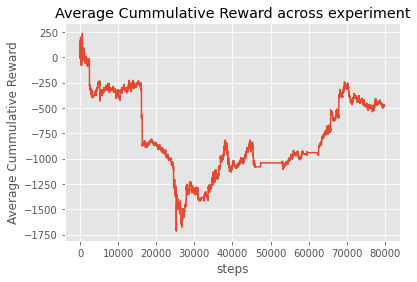

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
1999/1999 [==============================] - 19s 9ms/step - reward: 0.0336 - cumulative_reward: 123.9924
Episode 1: reward: 67.100, steps: 9999
test completed. total_reward: 67.09999999999557 total_profit: 0.9560060453287333
min reward: -457.79999999999933, max reward: 164.29999999999723, mean_reward: 0.006710671067106268


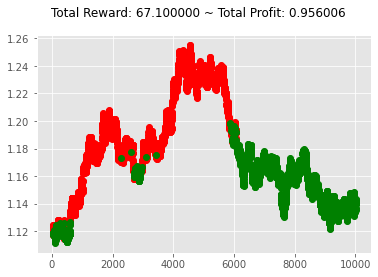

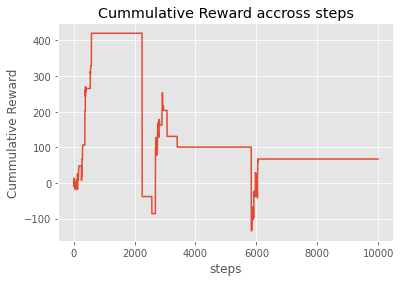

In [8]:
e.process_train_result()
e.test(ExternalDataFullFeature(df=EURUSD_HOUR, frame_bound=(80000, 90000), window_size=24))

### Dueling DQN

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 281s 18ms/step - reward: -0.1261 - cumulative_reward: -2417.0097
train 1 completed. took 285.422 seconds, total_reward: -2016.9999999997774 total_profit: 0.18962537622232636
min reward: -887.0, max reward: 498.8999999999999, mean_reward: -0.025228583221801115


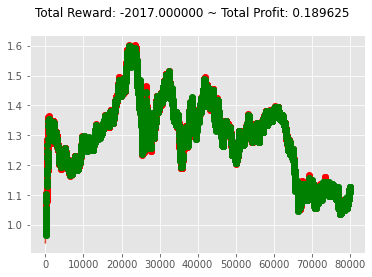

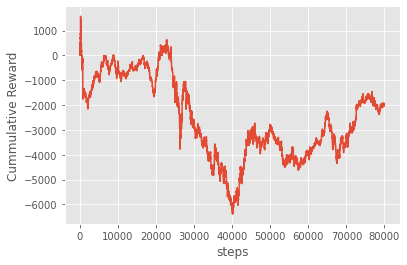

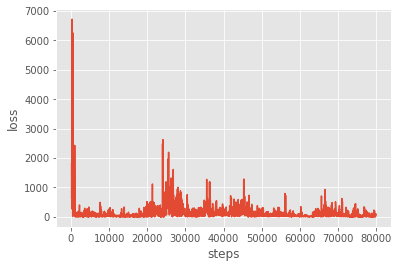

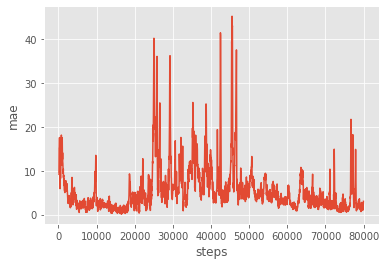

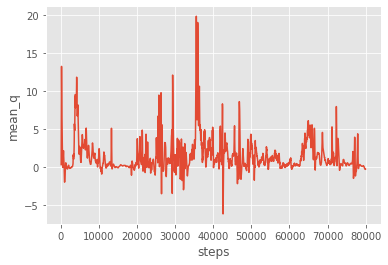

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 285s 18ms/step - reward: 5.3265 - cumulative_reward: -6518.7107
train 2 completed. took 578.455 seconds, total_reward: -9170.799999999865 total_profit: 0.12381497652155338
min reward: -1255.9999999999993, max reward: 643.4000000000007, mean_reward: -0.11470812643059781


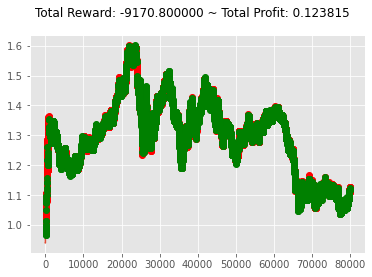

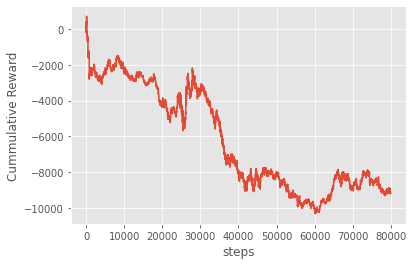

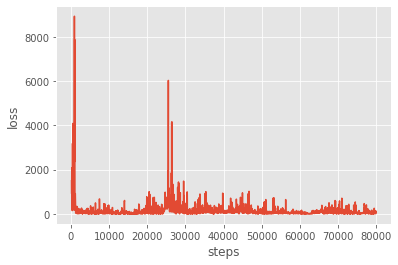

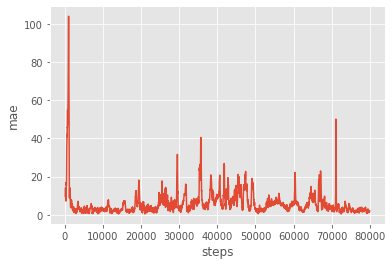

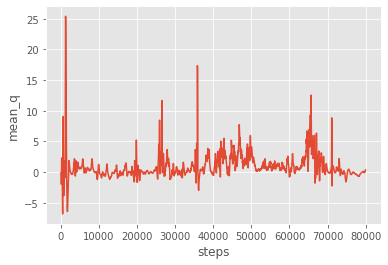

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 278s 17ms/step - reward: 30.5044 - cumulative_reward: -5245.1420
train 3 completed. took 864.477 seconds, total_reward: -9522.899999999974 total_profit: 0.08785035290656032
min reward: -531.7000000000016, max reward: 565.9999999999999, mean_reward: -0.11911218401731072


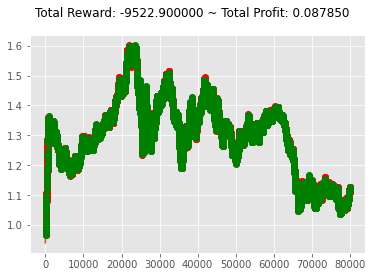

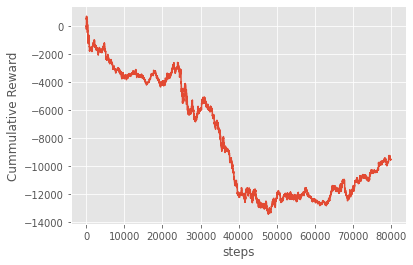

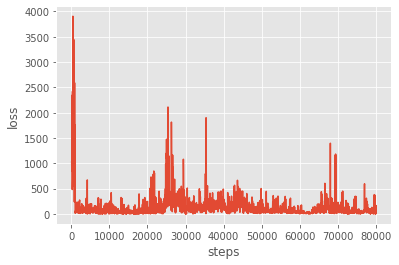

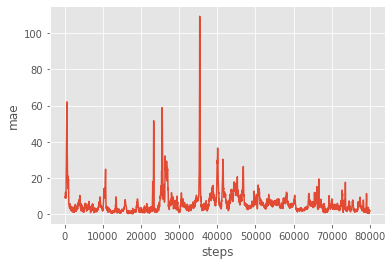

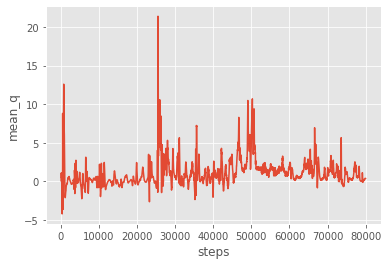

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 266s 17ms/step - reward: -0.0428 - cumulative_reward: -1144.2304
train 4 completed. took 1139.536 seconds, total_reward: -684.699999999967 total_profit: 0.10994898717276123
min reward: -654.9999999999989, max reward: 593.3999999999995, mean_reward: -0.008564209683672929


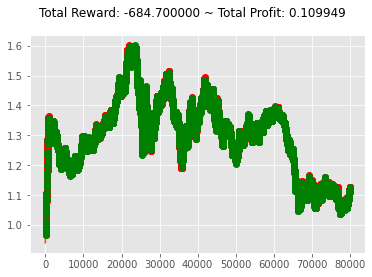

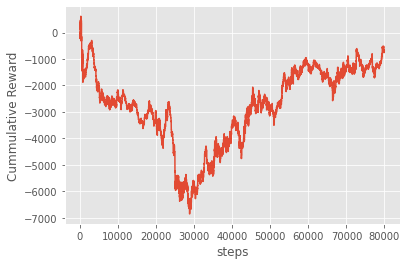

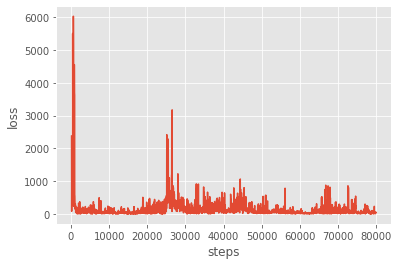

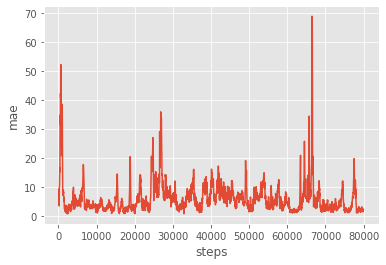

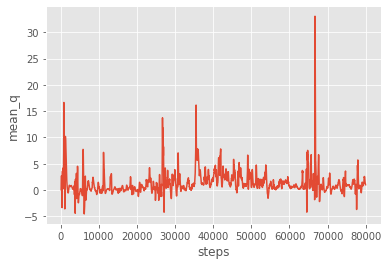

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 272s 17ms/step - reward: 8.0735 - cumulative_reward: 2364.2931
train 5 completed. took 1420.340 seconds, total_reward: 5972.600000000247 total_profit: 0.1672873151503224
min reward: -739.0000000000008, max reward: 869.9999999999997, mean_reward: 0.0747051245168826


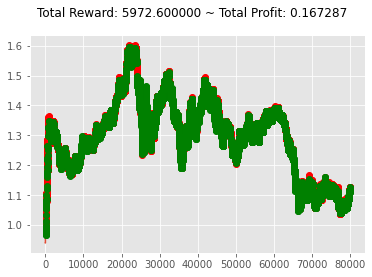

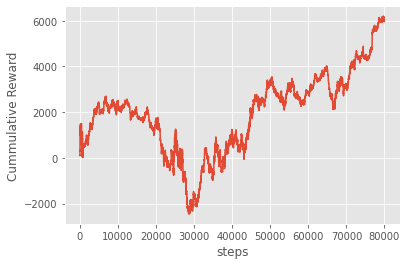

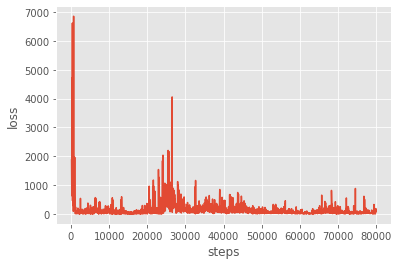

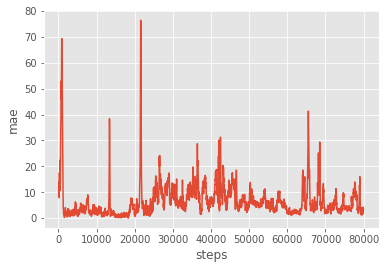

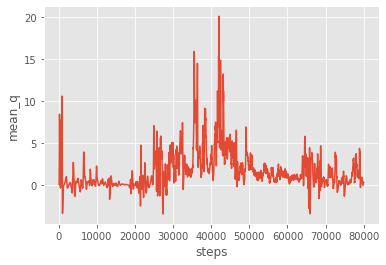

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 303s 19ms/step - reward: -34.7898 - cumulative_reward: -1882.9488
train 6 completed. took 1731.890 seconds, total_reward: -1436.599999999842 total_profit: 0.15648290180348676
min reward: -1257.0000000000014, max reward: 486.99999999999966, mean_reward: -0.01796895520894373


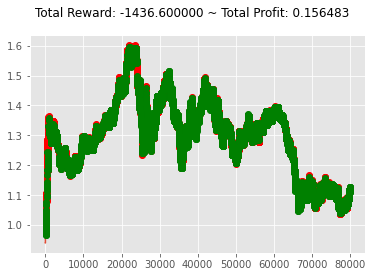

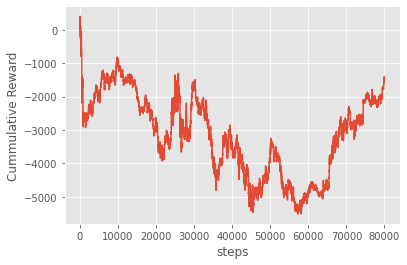

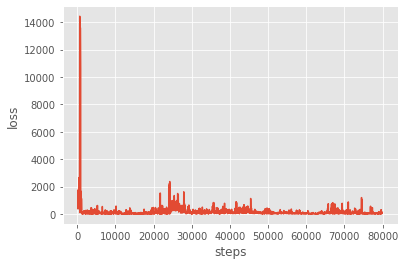

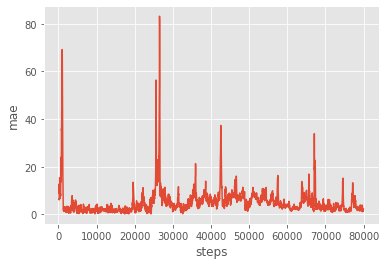

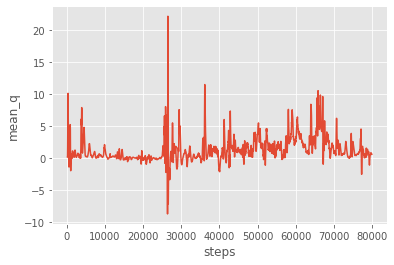

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 303s 19ms/step - reward: -47.2232 - cumulative_reward: -490.4935
train 7 completed. took 2043.638 seconds, total_reward: 1227.6999999998407 total_profit: 0.18154138835962783
min reward: -669.9999999999994, max reward: 474.0000000000011, mean_reward: 0.015356039475163424


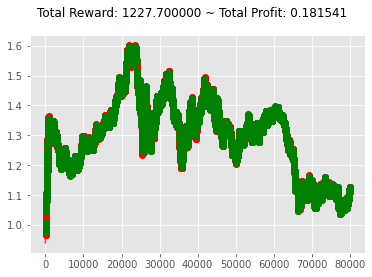

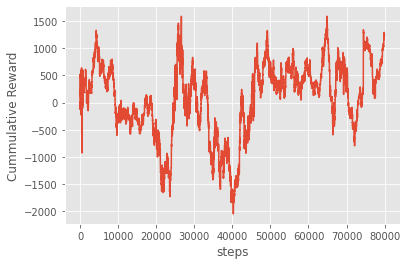

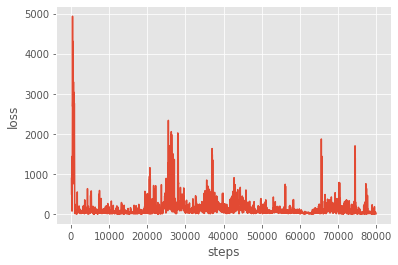

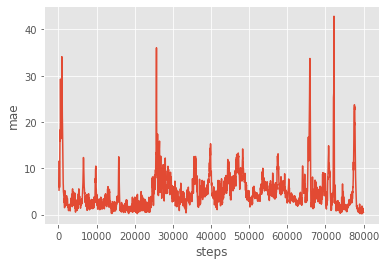

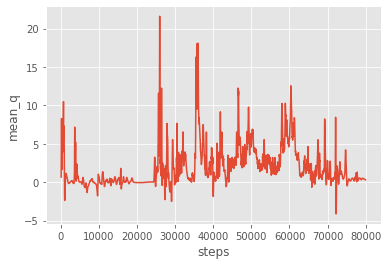

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 307s 19ms/step - reward: 45.3258 - cumulative_reward: 241.1861
train 8 completed. took 2361.003 seconds, total_reward: 3610.900000000078 total_profit: 0.15585612642132254
min reward: -1093.3999999999999, max reward: 519.4000000000032, mean_reward: 0.04516504271473162


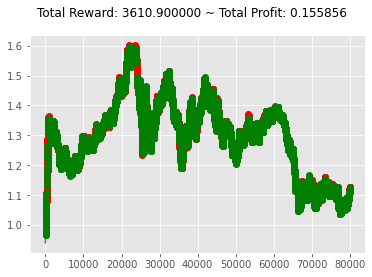

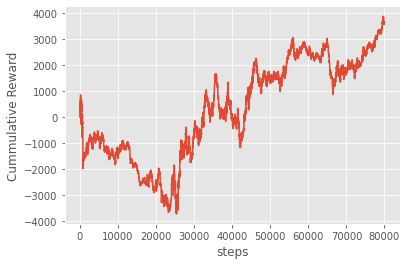

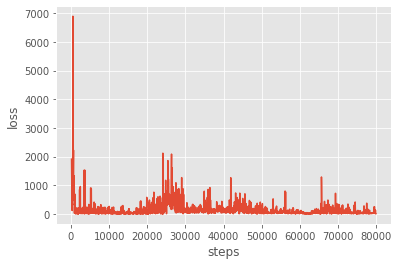

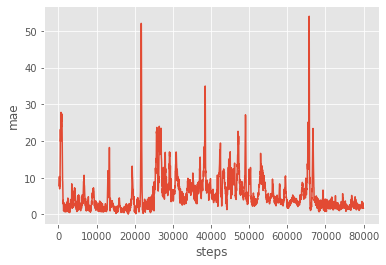

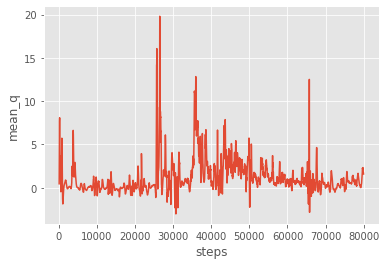

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 312s 20ms/step - reward: 46.9499 - cumulative_reward: -2192.2682
train 9 completed. took 2682.553 seconds, total_reward: -5598.200000000004 total_profit: 0.14052738905775722
min reward: -591.8999999999985, max reward: 621.0000000000005, mean_reward: -0.07002213911368503


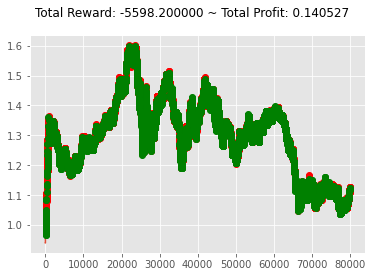

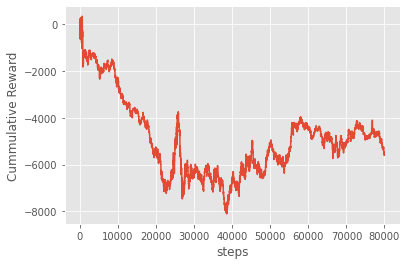

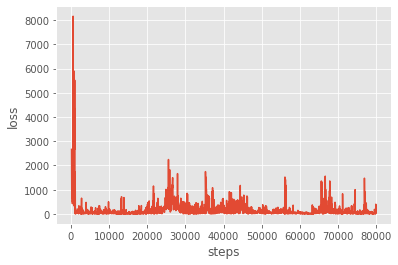

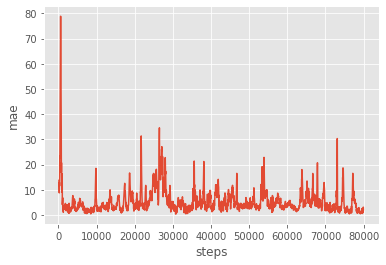

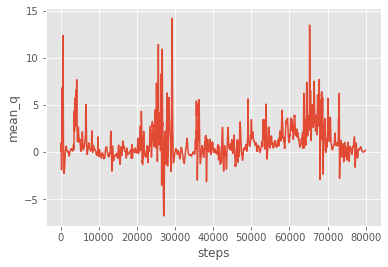

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 321s 20ms/step - reward: -0.2955 - cumulative_reward: -1748.0359
train 10 completed. took 3012.874 seconds, total_reward: -4725.3999999997295 total_profit: 0.12676144693388583
min reward: -878.000000000001, max reward: 447.9999999999995, mean_reward: -0.05910517955196099


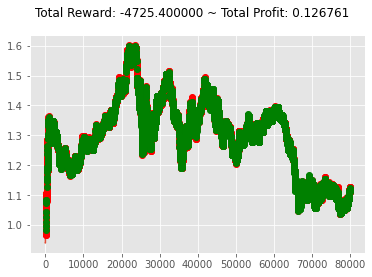

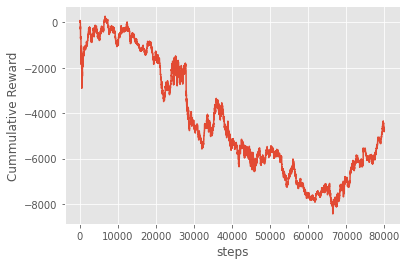

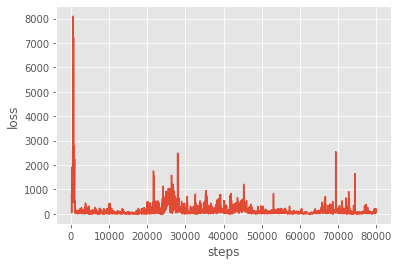

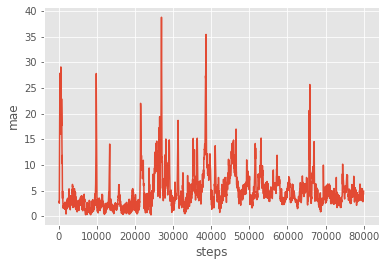

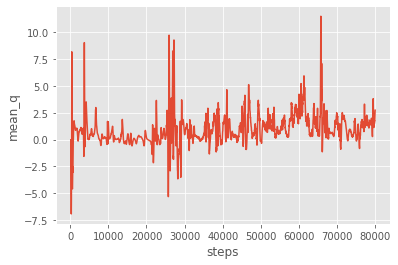

In [9]:
def agent_creator():
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=256, window_length=1)
    policy = EpsGreedyQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, enable_double_dqn=False, gamma=0.5, enable_dueling_network=True)
    agent.compile(Adam(lr=0.001), metrics=['mae'])
    return agent
e = Evaluator(agent_creator, env_creator, name="dueling_dqn-90k")
e.train(repeat=10)


average of total_reward across trainings: [-2234.44]


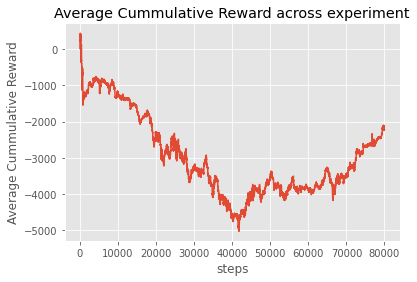

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
1999/1999 [==============================] - 24s 12ms/step - reward: 0.4998 - cumulative_reward: 386.2768
Episode 1: reward: 399.600, steps: 9999
test completed. total_reward: 399.6000000000489 total_profit: 0.890496844304128
min reward: -616.1000000000016, max reward: 119.70000000000036, mean_reward: 0.039963996399644854


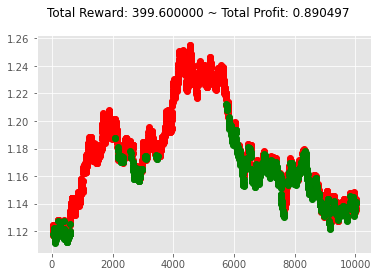

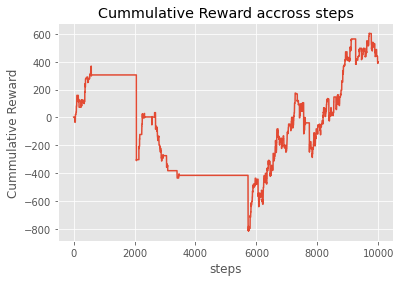

In [10]:
e.process_train_result()
e.test(ExternalDataFullFeature(df=EURUSD_HOUR, frame_bound=(80000, 90000), window_size=24))